In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix
from matplotlib.lines import Line2D

In [3]:
from sklearn import cluster, metrics
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE

# Import Data and Metadata

In [4]:
# Data was filtered to preserve one sample type per experimental condition 
data = pd.read_csv("../data/filtered_data.csv",index_col=0)

In [10]:
# Pull filtered metadata and format into Pandas DataFrame
Supp_data2 = pd.read_excel('../metadata/filtered_metadata.xls',skiprows=4,usecols = range (1,32))
Supp_data2

,Experiment,Library,Library Barcode,PPID,Specimen ID,Sample,Tissue Treatment,Tissue Treatment (Short),Tissue Collection (Short),Nuclei Extraction Protocol,...,% Coding,% UTR,% Intronic,% Intergenic,% MT,Post QC (>400 nonMT UMI; >400 <5000 nonMT Genes Detected).1,Used for Clustering Analysis,Useful reads,UMI,Duplication level
0,20161122,NK5,N705,3351,K1600543,K1600543_2,RNAlater 6 Hours,RNAlater,Nephrectomy,NEB/Dounce,...,8.84,3.59,48.93,38.64,0.476256,80,yes,181896.0,92994.0,0.488752
1,20171016A,NK9,N703,3395,K1700233,K1700233_8,"Flash Frozen, Cryosection (35umx7) OCT embedded",Cryosection,Nephrectomy,NEB/Dounce,...,24.09,3.79,39.66,32.47,17.118767,741,yes,1516531.0,753643.0,0.503048
2,20171016C,NK13,N705,3395,K1700233,K1700233_9,RNAlater 6 Hours,RNAlater,Nephrectomy,NEB/Dounce,...,20.06,2.41,46.48,31.06,4.356989,177,yes,275203.0,150365.0,0.453622
3,20171214D,NK21,N720,3432,K1700578,K1700578_12,60 minutes Trypsin-Collagenase,Trypsin-Collagenase,Nephrectomy,NEB/Dounce,...,60.45,8.89,23.44,7.22,24.998104,782,yes,1054658.0,738702.0,0.299581
4,20171214A,NK25,N706,3431,K1700572,K1700572_11,30 minutes Papain-Collagenase,Papian-Collagenase,Nephrectomy,NEB/Dounce,...,41.23,8.85,41.79,8.12,2.907478,350,yes,1684831.0,406276.0,0.758862
5,20180123C,NK27,N711,3435,K1800017,K1800017_5FB,"Dry-ice frozen, 5x40uM Sections - Wisc Soln",Cryosection-Wisc,Nephrectomy,NEB/Dounce,...,57.78,9.69,24.74,7.79,29.062712,177,yes,1086360.0,284369.0,0.740000
6,20180123C,NK28,N712,3435,K1800017,K1800017_5FB,"Dry-ice frozen, 5x40uM Sections - Wisc Soln",Cryosection-Wisc,Nephrectomy,NEB/Dounce,...,55.14,9.85,26.96,8.05,26.754064,193,yes,1451490.0,308772.0,0.790000
7,20180123D,NK29,N714,3435,K1800017,K1800017_5FB,"Dry-ice frozen, 5x40uM Sections - RNAlater",Cryosection-RNAlater,Nephrectomy,NEB/Dounce,...,38.00,10.64,43.98,7.38,3.451212,197,yes,1666541.0,275335.0,0.830000
8,20180123D,NK30,N715,3435,K1800017,K1800017_5FB,"Dry-ice frozen, 5x40uM Sections - RNAlater",Cryosection-RNAlater,Nephrectomy,NEB/Dounce,...,37.18,10.65,44.77,7.40,2.854999,188,yes,1385188.0,241267.0,0.830000
9,20180123A,NK31,N716,3434,K1800010,K1800010_4,30 minutes Papain-Collagenase - RNAlater,Papian-Collagenase,Nephrectomy,NEB/Dounce,...,32.07,6.38,53.40,8.15,1.965794,147,yes,720470.0,125326.0,0.830000


# Run Dimension Reduction

## Setup Colormap for Data

In [7]:
labels = pd.DataFrame()
groups = Supp_data2.groupby("Library")
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
c_map = {}
num=0
for i,j in groups:
    c_map.update({i:colors[num]})
    num+=1
data_colors = []
for i in data.columns:
    data_colors.append(c_map[i.split("_")[1]])

## Transform and Run Dimension Reduction

In [21]:
# Non-standard normalization in order to preserve sparsity, as z-scores fail to execute
# due to mathematical error of dividing by zero
scaler = StandardScaler(with_mean=False)
scaler.fit(data.transpose())
norm_data = scaler.transform(data.transpose())

# Run PCA
pca= PCA(300).fit(norm_data)
%time pca_transform = pca.fit_transform(norm_data)
print("Total Variance Explained: "+str(sum(pca.explained_variance_ratio_)))

Total Variance Explained: 0.2617171997589764


In [45]:
# Run FactorAnalysis transform
factor_analysis = FactorAnalysis(300).fit(norm_data)
%time fa_transform = factor_analysis.fit_transform(norm_data)

CPU times: user 39min 14s, sys: 4min 3s, total: 43min 18s
Wall time: 5min 37s


Text(0, 0.5, 'PC 2: 0.60%')

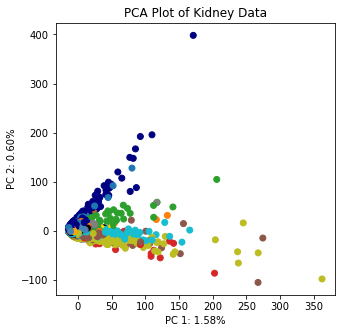

In [44]:
fig,ax = plt.subplots(figsize=[5,5])
ax.scatter(pca_transform[:,0],pca_transform[:,1],c=data_colors)
ax.set_title("PCA Plot of Kidney Data")
ax.set_xlabel("PC 1: %.2f" % float(pca.explained_variance_ratio_[0]*100) +"%")
ax.set_ylabel("PC 2: %.2f" % float(pca.explained_variance_ratio_[1]*100) +"%")

(-1.0, 12.0)

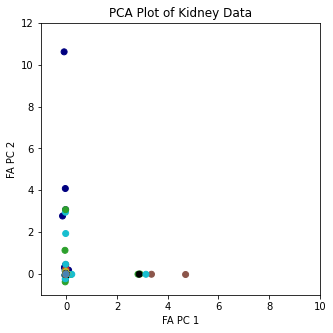

In [51]:
fig,ax = plt.subplots(figsize=[5,5])
ax.scatter(fa_transform[:,0],fa_transform[:,1],c=data_colors)
ax.set_title("PCA Plot of Kidney Data")
ax.set_xlabel("FA PC 1")
ax.set_ylabel("FA PC 2")
ax.set_xlim([-1,10])
ax.set_ylim([-1,12])

# Plot in 2D

## UMAP Dimensionality Reduction

### PCA --> UMAP

In [22]:
fit = umap.UMAP()
%time u_pca = fit.fit_transform(pca_transform)

CPU times: user 21.8 s, sys: 820 ms, total: 22.7 s
Wall time: 5.23 s


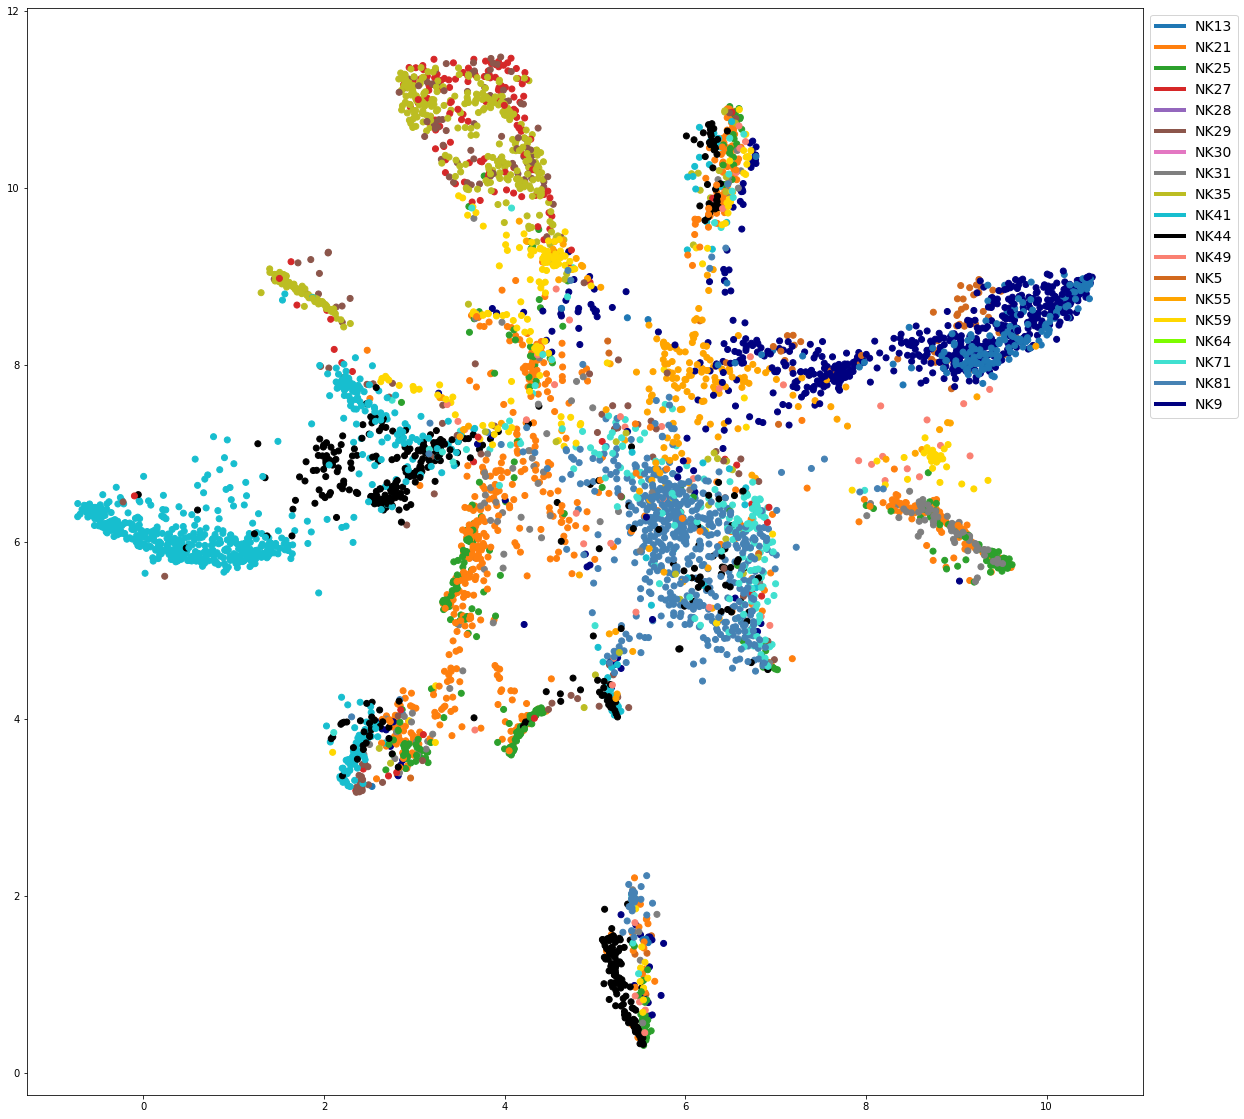

In [23]:
fig,ax = plt.subplots(figsize=[20,20])
ax.scatter(u_pca[:,0],u_pca[:,1],c=data_colors)

custom_lines = []
for i,j in c_map.items():
    custom_lines.append(Line2D([0], [0], color=j, lw=4))
ax.legend(custom_lines,list(c_map.keys()),bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)

### Factor Analysis --> UMAP

In [24]:
%time u_fa = fit.fit_transform(fa_transform)

CPU times: user 20.8 s, sys: 915 ms, total: 21.7 s
Wall time: 5.33 s


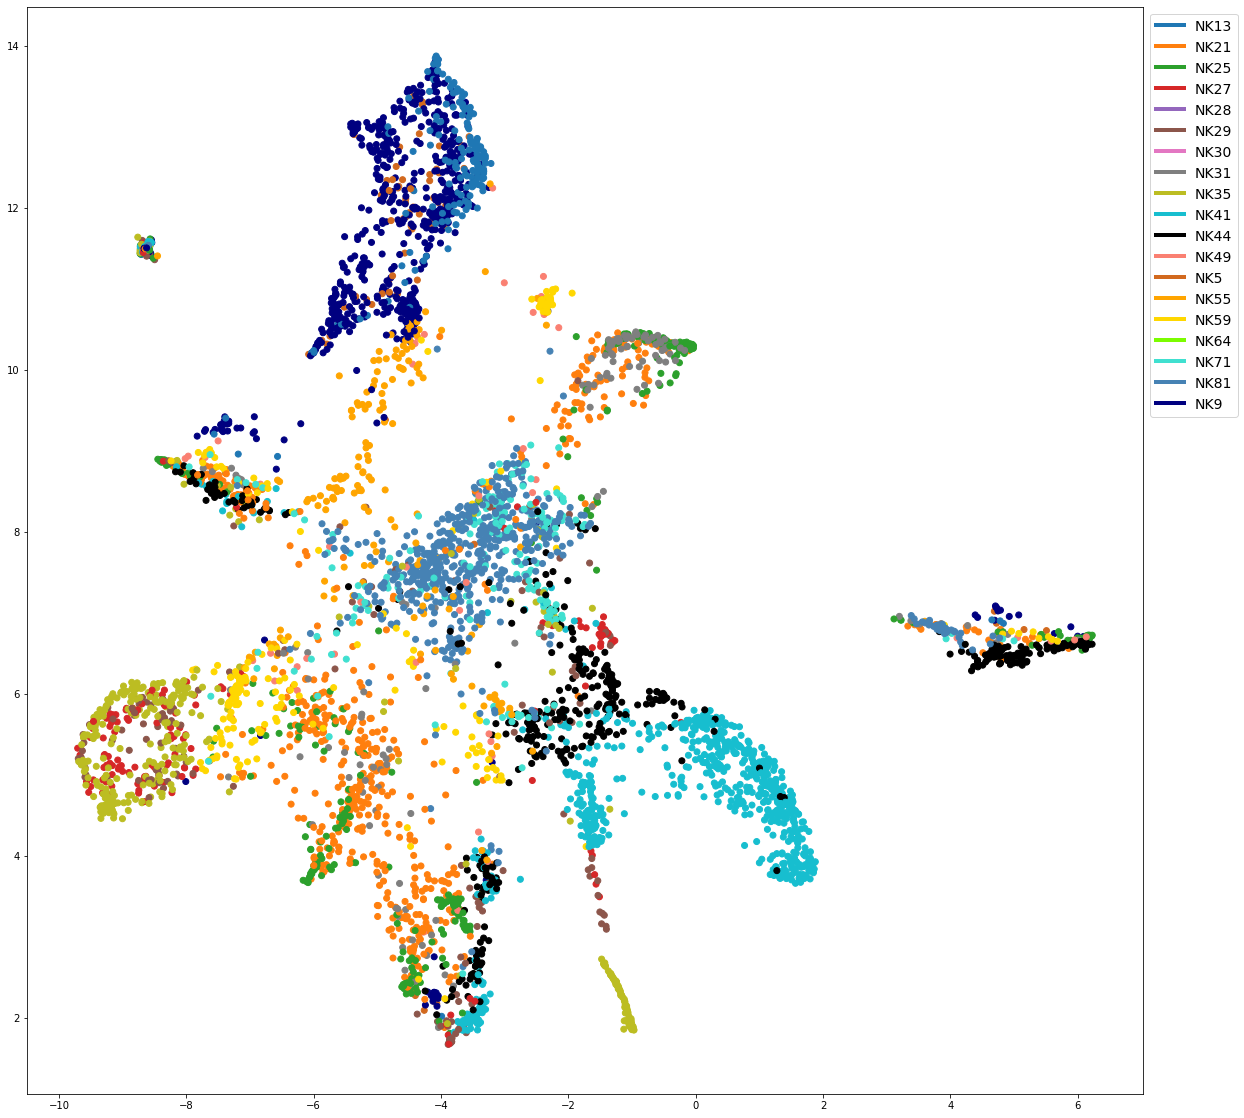

In [25]:
fig,ax = plt.subplots(figsize=[20,20])
ax.scatter(u_fa[:,0],u_fa[:,1],c=data_colors)

custom_lines = []
for i,j in c_map.items():
    custom_lines.append(Line2D([0], [0], color=j, lw=4))
ax.legend(custom_lines,list(c_map.keys()),bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)

### PCA --> TSNE

In [26]:
%time tsne_pca = TSNE(n_components=2).fit_transform(pca_transform)

CPU times: user 2min 5s, sys: 103 ms, total: 2min 5s
Wall time: 28.5 s


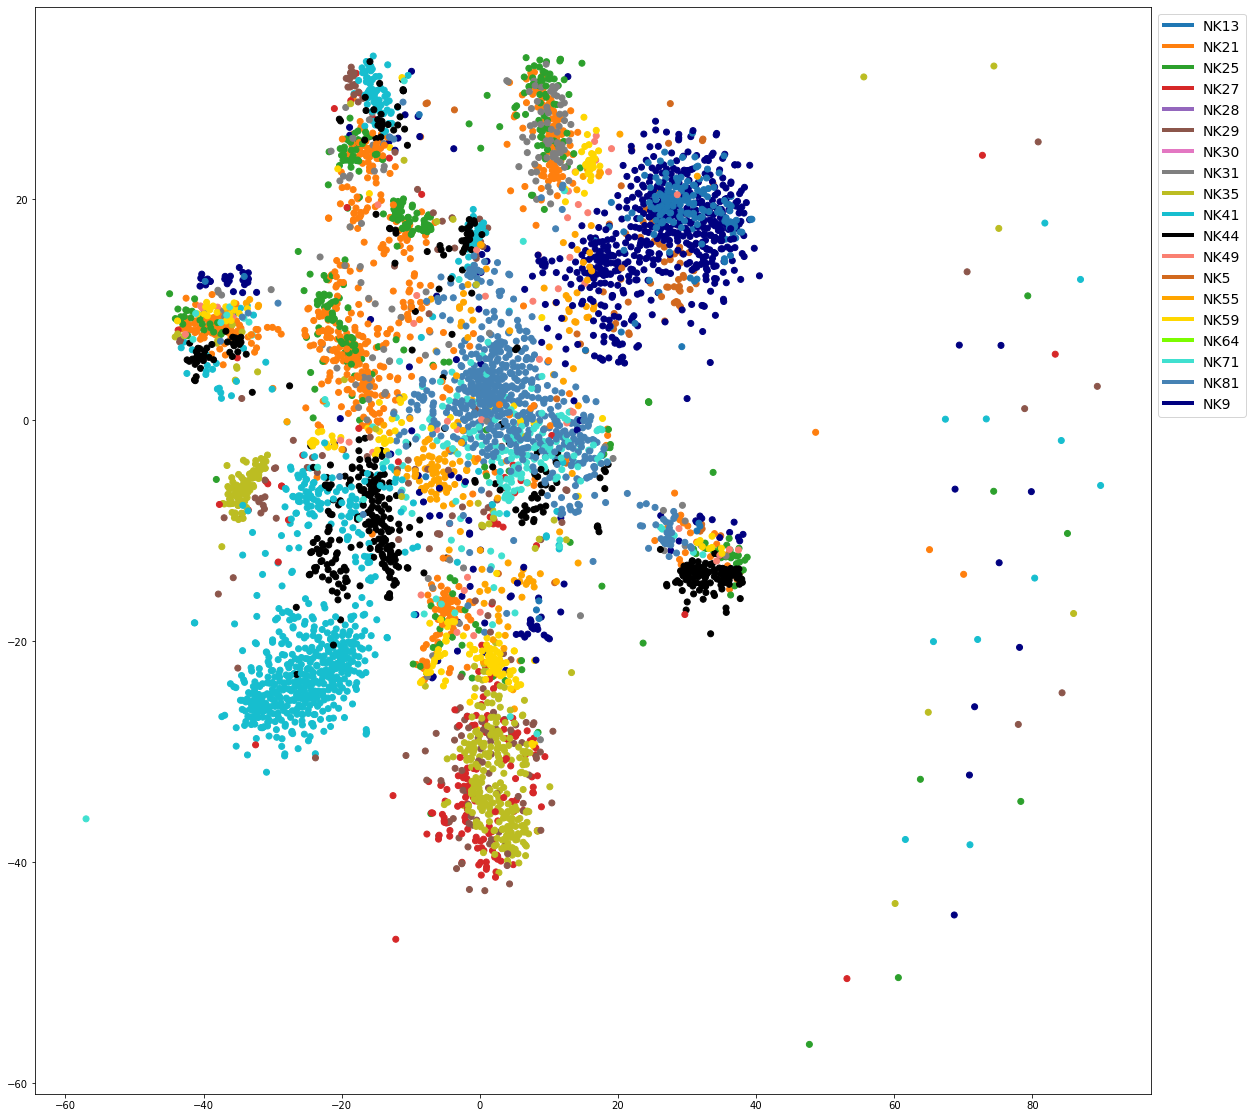

In [27]:
fig,ax = plt.subplots(figsize=[20,20])
ax.scatter(tsne_pca[:,0],tsne_pca[:,1],c=data_colors)
custom_lines = []
for i,j in c_map.items():
    custom_lines.append(Line2D([0], [0], color=j, lw=4))
ax.legend(custom_lines,list(c_map.keys()),bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)

### Factor Analysis --> TSNE

In [28]:
%time tsne_fa = TSNE(n_components=2).fit_transform(fa_transform)

CPU times: user 1min 41s, sys: 51.3 ms, total: 1min 41s
Wall time: 19.4 s


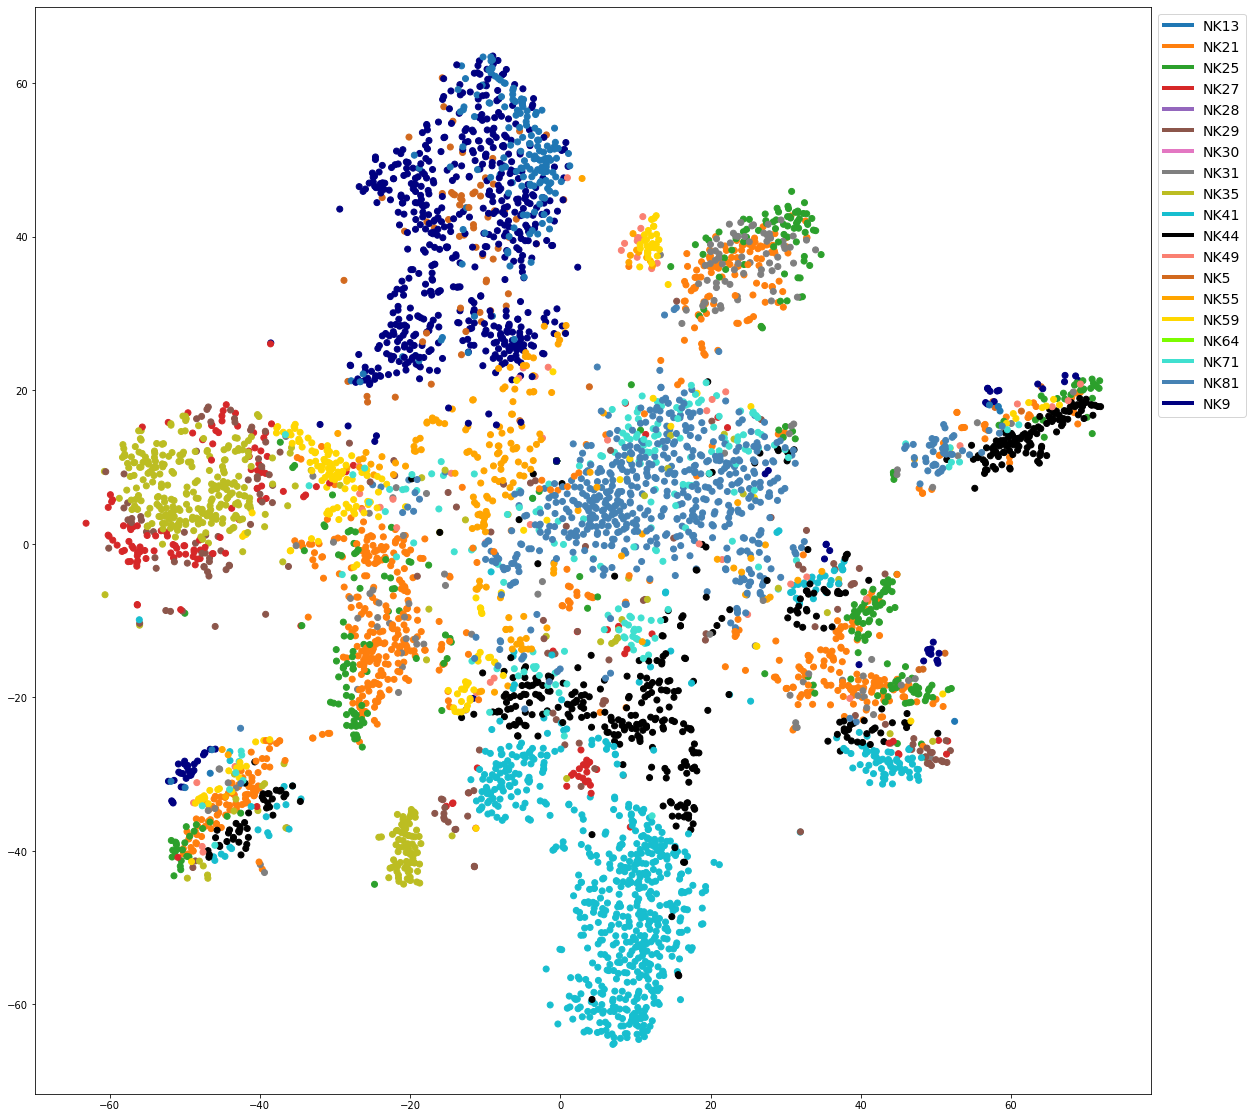

In [29]:
fig,ax = plt.subplots(figsize=[20,20])
ax.scatter(tsne_fa[:,0],tsne_fa[:,1],c=data_colors)
custom_lines = []
for i,j in c_map.items():
    custom_lines.append(Line2D([0], [0], color=j, lw=4))
ax.legend(custom_lines,list(c_map.keys()),bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)